# Übung 02 - Aufgabe 2

In [1]:
import os
import wget
import tarfile
import random

import pandas as pd
import numpy as np
from sklearn import preprocessing

from skimage import io
from skimage.transform import rescale, resize

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

from pca import pca

In [2]:
%reload_ext version_information
%version_information numpy, pandas, skimage, matplotlib, sklearn

Software versions
Python 3.6.12 64bit [GCC 9.3.0]
IPython 7.16.1
OS Linux 5.4.0 53 generic x86_64 with debian bullseye sid
numpy 1.18.5
pandas 1.1.3
skimage 0.17.2
matplotlib 3.3.2
sklearn 0.23.2
Sat Nov 14 13:56:12 2020 CET

## Aufgabe a.)
### Datensatz herunterladen


In [3]:
labeled_faces_tgz = 'lfw-funneled.tgz'
labeled_faces_folder = os.path.join(os.getcwd(), 'lfw_funneled')

if not os.path.isfile(labeled_faces_tgz):
    print("Downloading file...\n")

    wget.download('http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz', labeled_faces_tgz)
    dateDownloaded = !date #Calling Linux
    print("File downloaded on:", dateDownloaded[0])

    os.mkdir(labeled_faces_folder)

    with tarfile.open(labeled_faces_tgz) as tar:
        tar.extractall(path=os.getcwd())

    print("Files extracted")

## Aufgabe b.)
### Personen mit >= 70 Bildern finden.

In [4]:
faces_paths = []
faces_no = 0

for subdir, dirs, files in os.walk(labeled_faces_folder):
    if len(dirs) == 0:
        if len(files) >= 70:
            print(os.path.split(subdir)[-1], "has different images:", len(files))

            faces_paths.append(subdir)
            faces_no += len(files)

print()
print("Number of different faces", len(faces_paths))
print("Total number of faces", faces_no)

Donald_Rumsfeld has different images: 121
Hugo_Chavez has different images: 71
Ariel_Sharon has different images: 77
Tony_Blair has different images: 144
George_W_Bush has different images: 530
Colin_Powell has different images: 236
Gerhard_Schroeder has different images: 109

Number of different faces 7
Total number of faces 1288


### Funktionen zum stacken und plotten von Gesichtern

In [5]:
SCALE_SIZE = 32
INCLUDE_ALL_FACES = False
SHUFFLE_DATA = False

def convert_face_to_stacked_vector(_face_path):
    y1, y2 = 100, 180
    x1, x2 = 75, 175

    _face_ndarray = io.imread(_face_path, as_gray=True)
    _face_ndarray = _face_ndarray[y1:y2, x1:x2]
    _face_ndarray = resize(_face_ndarray, (SCALE_SIZE, SCALE_SIZE), anti_aliasing=True)

    return _face_ndarray.flatten()

def plot_face(_face_ndarray, reshape=True):
    if reshape:
        plt.imshow(_face_ndarray.reshape(SCALE_SIZE, SCALE_SIZE), cmap='gray')
    else:
        plt.imshow(_face_ndarray, cmap='gray')

    plt.show()

### Erstellen der Designmatrix & Labels der Trainingsgesichter

In [6]:
test_paths = []

x_train = []
y_train = []

for faces_path in faces_paths:
    label = os.path.split(faces_path)[-1]
    faces = [files for _, _, files in os.walk(faces_path)][0]

    if SHUFFLE_DATA:
        random.shuffle(faces)
    else:
        faces.sort()

    test_paths.append(os.path.join(faces_path, faces.pop()))

    for face in faces:
        face_path = os.path.join(faces_path, face)

        x_train.append(convert_face_to_stacked_vector(face_path))
        y_train.append(label)

x_train = pd.DataFrame(x_train).to_numpy() # train - designmatrix
y_train = pd.DataFrame(y_train).to_numpy() # train - label vector

print("x_train shape:", x_train.shape, " - (train - designmatrix)")
print("y_train shape:", y_train.shape, " - (train - label vector)")

x_train shape: (1281, 1024)  - (train - designmatrix)
y_train shape: (1281, 1)  - (train - label vector)


### Optional: Hinzufügen aller Personen des Datensatzes zum Testdatensatz

In [7]:
if INCLUDE_ALL_FACES:
    for subdir, dirs, files in os.walk(labeled_faces_folder):
        if len(dirs) == 0:
            files.sort()
            test_path = os.path.join(subdir, files.pop())

            if test_path not in test_paths:
                test_paths.append(test_path)

test_paths.sort()
print("Number of test faces", len(test_paths))

Number of test faces 7


### Erstellen der Designmatrix & Labels der Testgesichter

In [8]:
x_test = []
y_test = []

for test_path in test_paths:
    label = os.path.split(os.path.split(test_path)[0])[-1]

    x_test.append(convert_face_to_stacked_vector(test_path))
    y_test.append(label)

x_test = pd.DataFrame(x_test).to_numpy() # test - designmatrix
y_test = pd.DataFrame(y_test).to_numpy() # test - label vector

print("x_test shape:", x_test.shape, " - (test - designmatrix)")
print("y_test shape:", y_test.shape, " - (test - label vector)")

x_test shape: (7, 1024)  - (test - designmatrix)
y_test shape: (7, 1)  - (test - label vector)


## Aufgabe c.)
### Hauptkomponentenanalyse der Trainingsdaten

In [9]:
q_r, scores, variances, sum_variance, scores_var, exp_var, error_p = pca(x_train, 150)

,0
0,270.124046
1,164.460474
2,68.448984
3,39.265322
4,35.499775
...,...
1019,0.000050
1020,0.000049
1021,0.000042
1022,0.000036


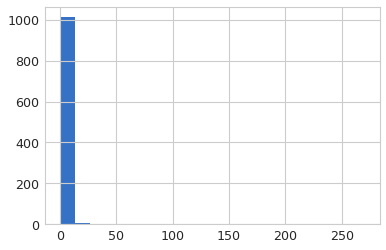

In [10]:
_ = plt.hist(variances, bins=20)

pd.DataFrame(variances)

### Plotten der ersten 12 Eigengesichter

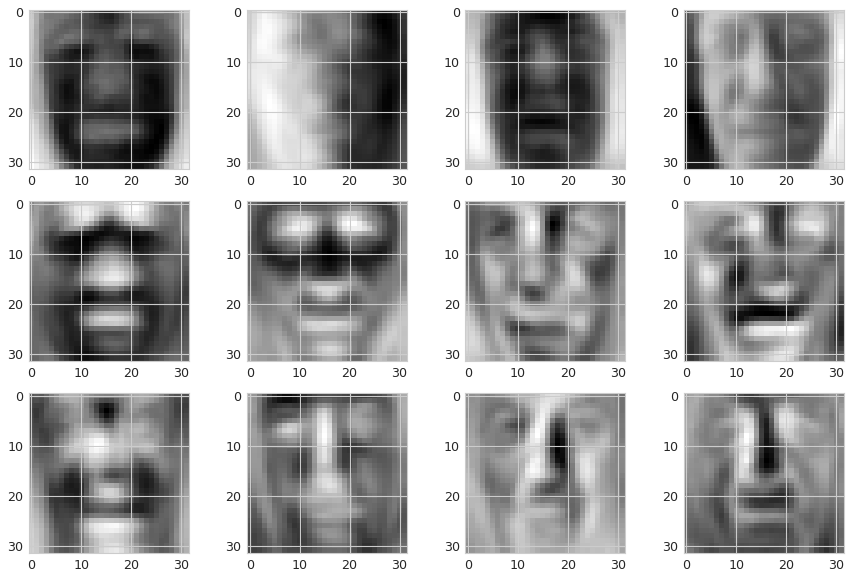

In [11]:
ncols, nrows = 4, 3

fig = plt.figure(figsize=(15,10))
gs = GridSpec(ncols=ncols, nrows=nrows, figure=fig)

for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs[i, j])

        img = q_r[:, (i * ncols + j)].reshape(SCALE_SIZE, SCALE_SIZE)

        ax.imshow(img, cmap='gray')

plt.show()

## Aufgabe d.)

### Test- & Trainingsbilder zentrieren und skalieren.

In [12]:
standard_scaler = preprocessing.StandardScaler()

x_train_centered = x_train - x_train.mean()
x_train_scaled = pd.DataFrame(standard_scaler.fit_transform(x_train_centered)).to_numpy()
train_projection = x_train_scaled @ q_r[:, :7]

x_test_centered = x_test - x_train.mean()
x_test_scaled = pd.DataFrame(standard_scaler.fit_transform(x_test_centered)).to_numpy()

### Euklidische Distanz der Test- & Trainingsprojektion berechnen und Minimum darstellen

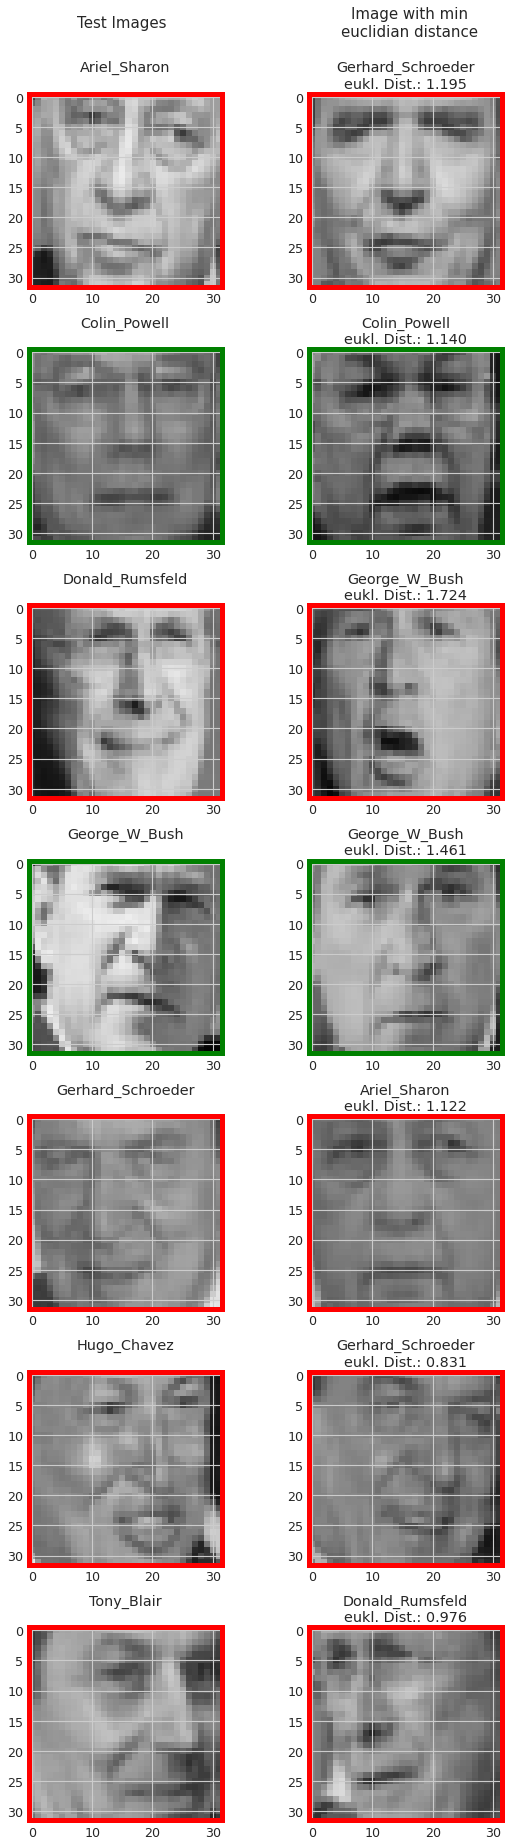

In [13]:
fig = plt.figure(figsize=(10,25))
gs = GridSpec(ncols=2, nrows=7, figure=fig)

plt.figtext(0.30, 1.015, "Test Images", va="center", ha="center", size=15)
plt.figtext(0.70, 1.015, "Image with min\neuclidian distance", va="center", ha="center", size=15)

for i in range(7):
    test_projection = np.matmul(x_test_scaled[i], q_r[:, :7])

    min_val = np.inf
    min_index = -1

    for j in range(len(train_projection)):
        tmp_min = np.linalg.norm(train_projection[j] - test_projection) / 7
        if tmp_min < min_val:
            min_val = tmp_min
            min_index = j

    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])

    if y_test[i][0] != y_train[min_index][0]:
        color = 'red'
    else:
        color = 'green'

    for ax in [ax1, ax2]:
        for spine in ax.spines:
            ax.spines[spine].set_color(color)
            ax.spines[spine].set_linewidth(5)

    io.imshow(x_test[i].reshape(SCALE_SIZE, SCALE_SIZE), cmap="gray", ax=ax1)
    ax1.set_title(y_test[i][0] + "\n")

    io.imshow(x_train[min_index].reshape(SCALE_SIZE, SCALE_SIZE), cmap="gray", ax=ax2)
    ax2.set_title("{name}\neukl. Dist.: {eukl_dist:.3f}".format(
        name=y_train[min_index][0], eukl_dist=min_val)
    )